In this notebook, we will be exploring the data of a French customer-to-customer clothing company, as well as visualizing clusters extracted from this high-dimensional data. 

# Importing Our Data and Libraries

In [1]:
#importing our libraries
#https://data.world/jfreex/e-commerce-users-of-a-french-c2c-fashion-store
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from kneed import KneeLocator 

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA
#from sklearn.manifold import TSNE
from MulticoreTSNE import MulticoreTSNE as TSNE
from mpl_toolkits.mplot3d import Axes3D

import plotly as py
import plotly.graph_objs as go
import plotly.express as px
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [2]:
udf = pd.read_csv('6M-0K-99K.users.dataset.public.csv')

# Data Cleaning and Feature Engineering

We start our analysis by loading in and examining our user data to see if there are any null values, as well as identifying any features we can add or remove. I also create a list of the data frame's column names in case we have to reference it down the line. 

In [3]:
udf_cols = list(udf.columns)
udf.head()

,identifierHash,type,country,language,socialNbFollowers,socialNbFollows,socialProductsLiked,productsListed,productsSold,productsPassRate,...,civilityTitle,hasAnyApp,hasAndroidApp,hasIosApp,hasProfilePicture,daysSinceLastLogin,seniority,seniorityAsMonths,seniorityAsYears,countryCode
0,-1097895247965112460,user,Royaume-Uni,en,147,10,77,26,174,74.0,...,mr,True,False,True,True,11,3196,106.53,8.88,gb
1,2347567364561867620,user,Monaco,en,167,8,2,19,170,99.0,...,mrs,True,False,True,True,12,3204,106.80,8.90,mc
2,6870940546848049750,user,France,fr,137,13,60,33,163,94.0,...,mrs,True,False,True,False,11,3203,106.77,8.90,fr
3,-4640272621319568052,user,Etats-Unis,en,131,10,14,122,152,92.0,...,mrs,True,False,True,False,12,3198,106.60,8.88,us
4,-5175830994878542658,user,Etats-Unis,en,167,8,0,25,125,100.0,...,mrs,False,False,False,True,22,2854,95.13,7.93,us


In [4]:
udf.shape

(98913, 24)

We see that our data frame contains 98,913 users x 24 features. There are also several columns that are redundant or simply not useful for us which we will remove later on. 

Taking a quick look at the data, we see that the average user is likely a female that has been using the platform for about 8.5 years. Socially, they have fewer than 4 followers and also follow about 8 people. Most users are also not active sellers, with the averages being 0.09 and 0.12 products listed and sold respectively. By comparison, it looks like users are generally window shoppers as they have 1-2 products on their wishlists while averaging less than 1 product purchase.

In [5]:
udf.describe()

,identifierHash,socialNbFollowers,socialNbFollows,socialProductsLiked,productsListed,productsSold,productsPassRate,productsWished,productsBought,civilityGenderId,daysSinceLastLogin,seniority,seniorityAsMonths,seniorityAsYears
count,9.891300e+04,98913.000000,98913.000000,98913.000000,98913.000000,98913.000000,98913.000000,98913.000000,98913.000000,98913.000000,98913.000000,98913.000000,98913.000000,98913.000000
mean,-6.692039e+15,3.432269,8.425677,4.420743,0.093304,0.121592,0.812303,1.562595,0.171929,1.773993,581.291236,3063.771870,102.125583,8.510424
std,5.330807e+18,3.882383,52.839572,181.030569,2.050144,2.126895,8.500205,25.192793,2.332266,0.428679,208.855888,168.298621,5.609735,0.467863
min,-9.223101e+18,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,11.000000,2852.000000,95.070000,7.920000
25%,-4.622895e+18,3.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,572.000000,2857.000000,95.230000,7.940000
50%,-1.337989e+15,3.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,694.000000,3196.000000,106.530000,8.880000
75%,4.616388e+18,3.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,702.000000,3201.000000,106.700000,8.890000
max,9.223331e+18,744.000000,13764.000000,51671.000000,244.000000,174.000000,100.000000,2635.000000,405.000000,3.000000,709.000000,3205.000000,106.830000,8.900000


We also see that there are no null values which means we do not have to worry about dropping rows or columns due to incomplete data. 

In [6]:
udf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98913 entries, 0 to 98912
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   identifierHash       98913 non-null  int64  
 1   type                 98913 non-null  object 
 2   country              98913 non-null  object 
 3   language             98913 non-null  object 
 4   socialNbFollowers    98913 non-null  int64  
 5   socialNbFollows      98913 non-null  int64  
 6   socialProductsLiked  98913 non-null  int64  
 7   productsListed       98913 non-null  int64  
 8   productsSold         98913 non-null  int64  
 9   productsPassRate     98913 non-null  float64
 10  productsWished       98913 non-null  int64  
 11  productsBought       98913 non-null  int64  
 12  gender               98913 non-null  object 
 13  civilityGenderId     98913 non-null  int64  
 14  civilityTitle        98913 non-null  object 
 15  hasAnyApp            98913 non-null 

At first glance, the country column stands out. Since this is a French company, the country names are in French so we will change the country names to English to improve readability. We see that there are 200 different countries represented in our data which means changing them manually will not be efficient. Fortunately we can import a file (cc) with this information already populated and join the data frames.

In [7]:
len(udf['country'].unique())

200

In [8]:
#https://github.com/lukes/ISO-3166-Countries-with-Regional-Codes/blob/master/all/all.csv
cc = pd.read_csv('CountryCodesRegions.csv')

In [9]:
cc.head()

,name,alpha-2,alpha-3,country-code,iso_3166-2,region,sub-region,intermediate-region,region-code,sub-region-code,intermediate-region-code
0,Afghanistan,AF,AFG,4,ISO 3166-2:AF,Asia,Southern Asia,NaN,142.0,34.0,NaN
1,Åland Islands,AX,ALA,248,ISO 3166-2:AX,Europe,Northern Europe,NaN,150.0,154.0,NaN
2,Albania,AL,ALB,8,ISO 3166-2:AL,Europe,Southern Europe,NaN,150.0,39.0,NaN
3,Algeria,DZ,DZA,12,ISO 3166-2:DZ,Africa,Northern Africa,NaN,2.0,15.0,NaN
4,American Samoa,AS,ASM,16,ISO 3166-2:AS,Oceania,Polynesia,NaN,9.0,61.0,NaN


Comparing our initial data with the new file containing country data, we will be joining the two data frames on the corresponding country code columns, labeled 'countryCode' and 'alpha-2' respectively. The country code data frame also has additional columns that can be used in our analysis, and we will drop the remaining columns. 

I also check the 'alpha-2' column to make sure the values loaded in properly as this is the column we will be merging on. Seeing that there is an nan value, I check what entries are missing a value and it appears that Namibia (code: NA) was imported as nan so we can fill this information in. 

In [10]:
cc['alpha-2'].unique()

array(['AF', 'AX', 'AL', 'DZ', 'AS', 'AD', 'AO', 'AI', 'AQ', 'AG', 'AR',
       'AM', 'AW', 'AU', 'AT', 'AZ', 'BS', 'BH', 'BD', 'BB', 'BY', 'BE',
       'BZ', 'BJ', 'BM', 'BT', 'BO', 'BQ', 'BA', 'BW', 'BV', 'BR', 'IO',
       'BN', 'BG', 'BF', 'BI', 'CV', 'KH', 'CM', 'CA', 'KY', 'CF', 'TD',
       'CL', 'CN', 'CX', 'CC', 'CO', 'KM', 'CG', 'CD', 'CK', 'CR', 'CI',
       'HR', 'CU', 'CW', 'CY', 'CZ', 'DK', 'DJ', 'DM', 'DO', 'EC', 'EG',
       'SV', 'GQ', 'ER', 'EE', 'SZ', 'ET', 'FK', 'FO', 'FJ', 'FI', 'FR',
       'GF', 'PF', 'TF', 'GA', 'GM', 'GE', 'DE', 'GH', 'GI', 'GR', 'GL',
       'GD', 'GP', 'GU', 'GT', 'GG', 'GN', 'GW', 'GY', 'HT', 'HM', 'VA',
       'HN', 'HK', 'HU', 'IS', 'IN', 'ID', 'IR', 'IQ', 'IE', 'IM', 'IL',
       'IT', 'JM', 'JP', 'JE', 'JO', 'KZ', 'KE', 'KI', 'KP', 'KR', 'KW',
       'KG', 'LA', 'LV', 'LB', 'LS', 'LR', 'LY', 'LI', 'LT', 'LU', 'MO',
       'MG', 'MW', 'MY', 'MV', 'ML', 'MT', 'MH', 'MQ', 'MR', 'MU', 'YT',
       'MX', 'FM', 'MD', 'MC', 'MN', 'ME', 'MS', 'M

In [11]:
cc[cc['alpha-2'].isna()]

,name,alpha-2,alpha-3,country-code,iso_3166-2,region,sub-region,intermediate-region,region-code,sub-region-code,intermediate-region-code
153,Namibia,NaN,NAM,516,ISO 3166-2:NA,Africa,Sub-Saharan Africa,Southern Africa,2.0,202.0,18.0


In [12]:
cc['alpha-2'].fillna('NA', inplace = True)

Since we are merging on the two letter country codes in both data frames, we will be converting the values in the 'alpha-2' column to lower case. We will also drop the columns we will not use before merging. 

In [13]:
cc['alpha-2'] = cc['alpha-2'].str.lower()

We keep the 'region' and 'sub-region' columns, in addition to 'alpha-2' and 'name', as we can use those columns in our analysis. 

In [14]:
cc.drop(['alpha-3', 'country-code', 'iso_3166-2', 'intermediate-region', 'region-code', 'sub-region-code',
       'intermediate-region-code'], axis=1, inplace=True)
cc.head()

,name,alpha-2,region,sub-region
0,Afghanistan,af,Asia,Southern Asia
1,Åland Islands,ax,Europe,Northern Europe
2,Albania,al,Europe,Southern Europe
3,Algeria,dz,Africa,Northern Africa
4,American Samoa,as,Oceania,Polynesia


Since we joined on two different named columns, we have duplicate columns for the country code so we can drop the duplicate country code column as well as the original country name column and rename the new name column.

In [15]:
newdf = pd.merge(udf, cc, left_on='countryCode', right_on='alpha-2', indicator = True, how='left')
newdf.sample(5)

,identifierHash,type,country,language,socialNbFollowers,socialNbFollows,socialProductsLiked,productsListed,productsSold,productsPassRate,...,daysSinceLastLogin,seniority,seniorityAsMonths,seniorityAsYears,countryCode,name,alpha-2,region,sub-region,_merge
67740,6216294145137236929,user,Espagne,es,3,9,3,0,0,0.0,...,93,2858,95.27,7.94,es,Spain,es,Europe,Southern Europe,both
82909,7889233628486406980,user,France,fr,3,8,0,0,0,0.0,...,693,2854,95.13,7.93,fr,France,fr,Europe,Western Europe,both
73957,568666664157311067,user,Espagne,es,3,8,0,0,0,0.0,...,695,2856,95.20,7.93,es,Spain,es,Europe,Southern Europe,both
8896,-1558854742789192743,user,Espagne,es,4,8,0,0,0,0.0,...,567,3198,106.60,8.88,es,Spain,es,Europe,Southern Europe,both
83908,2808348625202222062,user,Danemark,en,3,8,9,0,0,0.0,...,14,2854,95.13,7.93,dk,Denmark,dk,Europe,Northern Europe,both


In [16]:
newdf.drop(['country','alpha-2'], axis=1, inplace=True)
newdf.rename(columns={'name':'country'}, inplace=True)

In [17]:
newdf.sample(5)

,identifierHash,type,language,socialNbFollowers,socialNbFollows,socialProductsLiked,productsListed,productsSold,productsPassRate,productsWished,...,hasProfilePicture,daysSinceLastLogin,seniority,seniorityAsMonths,seniorityAsYears,countryCode,country,region,sub-region,_merge
72060,4274630642879547109,user,en,3,8,0,0,0,0.0,0,...,True,212,2857,95.23,7.94,us,United States of America,Americas,Northern America,both
42764,-7332083374344196075,user,fr,3,8,0,0,0,0.0,0,...,True,702,3198,106.60,8.88,fr,France,Europe,Western Europe,both
97041,1319251360528137337,user,en,3,8,0,0,0,0.0,0,...,True,708,3204,106.80,8.90,ie,Ireland,Europe,Northern Europe,both
15156,1134701271165065859,user,fr,3,8,0,0,0,0.0,0,...,True,709,3205,106.83,8.90,fr,France,Europe,Western Europe,both
55638,8325923972024068117,user,en,3,8,0,0,0,0.0,0,...,True,700,3196,106.53,8.88,nl,Netherlands,Europe,Western Europe,both


In [18]:
newdf.shape

(98913, 27)

We check to see if any of the entries are missing data after the merge. By adding the 'indicator' parameter when merging, a column is added to identify which entries only have data from one data frame. Seeing that there are only three entries missing data, we can drop them. It looks like the country code data we merged did not contain information for the Canary Islands or the Netherland Antilles, leading to nan values. 

In [19]:
newdf[newdf['_merge'] != 'both']

,identifierHash,type,language,socialNbFollowers,socialNbFollows,socialProductsLiked,productsListed,productsSold,productsPassRate,productsWished,...,hasProfilePicture,daysSinceLastLogin,seniority,seniorityAsMonths,seniorityAsYears,countryCode,country,region,sub-region,_merge
1955,-8715033061566320444,user,es,3,8,0,1,1,0.0,0,...,True,106,2857,95.23,7.94,ic,NaN,NaN,NaN,left_only
61002,-2587565045309476867,user,en,3,8,0,0,0,0.0,0,...,True,699,3195,106.50,8.88,an,NaN,NaN,NaN,left_only
77694,-5031806439755542220,user,es,3,8,0,0,0,0.0,0,...,True,695,2856,95.20,7.93,ic,NaN,NaN,NaN,left_only


In [20]:
newdf = newdf.loc[newdf['_merge'] == 'both']

In [21]:
newdf

,identifierHash,type,language,socialNbFollowers,socialNbFollows,socialProductsLiked,productsListed,productsSold,productsPassRate,productsWished,...,hasProfilePicture,daysSinceLastLogin,seniority,seniorityAsMonths,seniorityAsYears,countryCode,country,region,sub-region,_merge
0,-1097895247965112460,user,en,147,10,77,26,174,74.0,104,...,True,11,3196,106.53,8.88,gb,United Kingdom of Great Britain and Northern I...,Europe,Northern Europe,both
1,2347567364561867620,user,en,167,8,2,19,170,99.0,0,...,True,12,3204,106.80,8.90,mc,Monaco,Europe,Western Europe,both
2,6870940546848049750,user,fr,137,13,60,33,163,94.0,10,...,False,11,3203,106.77,8.90,fr,France,Europe,Western Europe,both
3,-4640272621319568052,user,en,131,10,14,122,152,92.0,7,...,False,12,3198,106.60,8.88,us,United States of America,Americas,Northern America,both
4,-5175830994878542658,user,en,167,8,0,25,125,100.0,0,...,True,22,2854,95.13,7.93,us,United States of America,Americas,Northern America,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98908,-5324380437900495747,user,fr,3,8,0,0,0,0.0,0,...,True,708,3204,106.80,8.90,us,United States of America,Americas,Northern America,both
98909,-5607668753771114442,user,fr,3,8,0,0,0,0.0,0,...,True,695,3204,106.80,8.90,fr,France,Europe,Western Europe,both
98910,350630276238833248,user,en,3,8,0,0,0,0.0,0,...,True,520,3204,106.80,8.90,be,Belgium,Europe,Western Europe,both
98911,2006580738726207028,user,it,3,8,0,0,0,0.0,0,...,True,267,3204,106.80,8.90,it,Italy,Europe,Southern Europe,both


# EDA

Even though we still have some redundant columns, we can visualize a few of those columns and extract insights before dropping them. Creating a correlation plot allows us to see if there are any relationships that stand out. 

From our correlation plot we see that:

   -Users with more followers tend to be more active as they follow more users and generally       like, list, wish, and have more products pass the store's inspection

-Profile picture status correlates inversely with most other features, particularly the social features

-The social features generally correlate positively with one another, hinting at the fact that the users do actually want and use those features 

<AxesSubplot:>

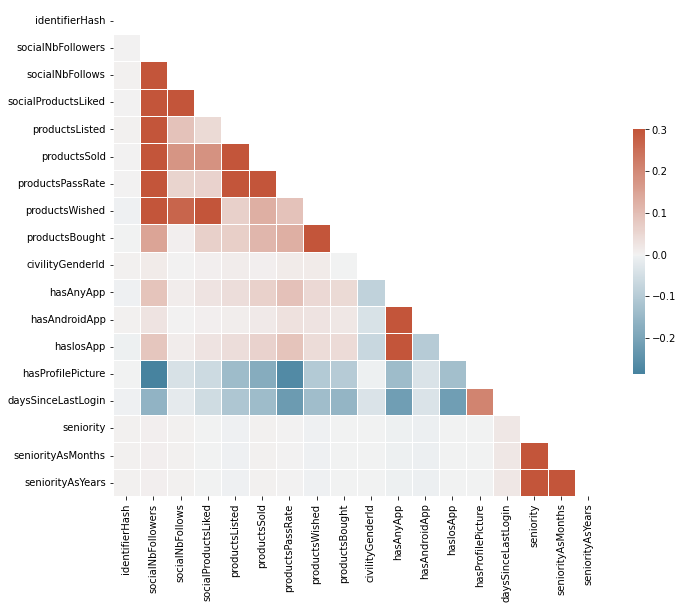

In [22]:
corr = newdf.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11,9))
cmap = sns.diverging_palette(230, 20, as_cmap = True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Looking at the 'hasAnyApp' column, we can try to see if the app has any influence in terms of users buying and selling. 

Users without the app appear to buy more than twice as much as they sell, while users with at least one app tend to buy and sell products at similar quanities. If the company is looking to get more users to sell products, they could look into promoting the app to users that do not use either app. This may be a sign that the app is much easier to use for selling items than on a computer. It could also be that computers are more difficult to purchase in lower income countries than a smartphone so the app provides easier access in those countries. 

In [23]:
app_sb = newdf[['hasAnyApp','productsSold','productsBought']]
app_sb = app_sb.groupby(['hasAnyApp']).sum()
app_sb

,productsSold,productsBought
hasAnyApp,,
False,3232,7957
True,8794,9049


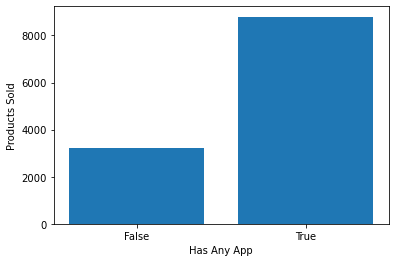

In [24]:
plt.bar(['False','True'], app_sb['productsSold'])
plt.xlabel('Has Any App')
plt.ylabel('Products Sold')
plt.show()

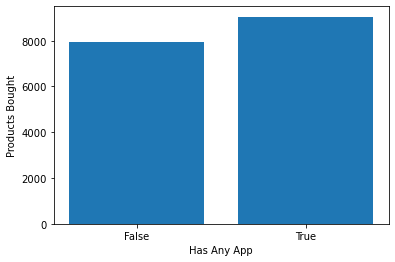

In [25]:
plt.bar(['False','True'], app_sb['productsBought'])
plt.xlabel('Has Any App')
plt.ylabel('Products Bought')
plt.show()

Looking at app users by country and language, we see that the countries with the most users are western European along with the United States and Australia. Similarly, we see that the top languages are represented in the dataset coincide with the top countries as English, French, Italian, German, and Spanish as the top 5 user languages, in order. This is not entirely surprising as this is a French company. We can also look at this from another perspective and acknowledge that this may be due to the larger popuations these countries have than other countries represented in this dataset; or it is due to higher median incomes in these countries which translates to more users buying/selling more items, or even affording a smartphone in the first place.


In [26]:
app_c = newdf.loc[newdf['hasAnyApp'] == True][['hasAnyApp','country']]

C:\Users\jvasq\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



[Text(0.5, 0, 'Country'), Text(0, 0.5, 'Users')]

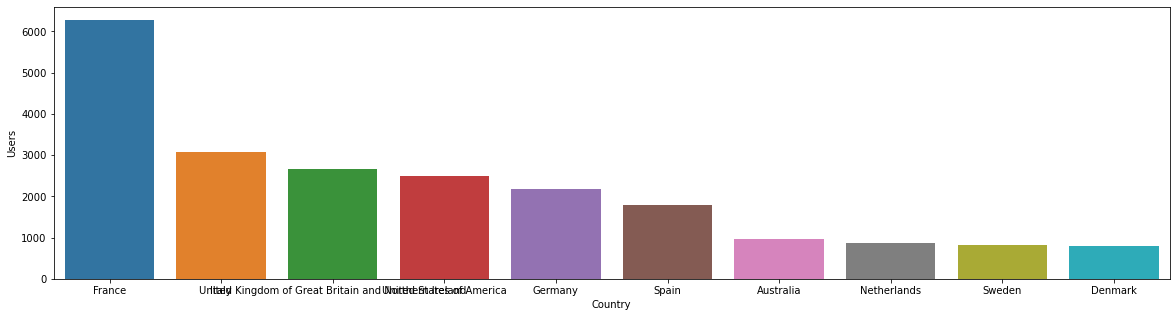

In [27]:
fig, ac = plt.subplots(figsize=(20,5))
ac = sns.barplot(app_c['country'].value_counts().head(10).index, app_c['country'].value_counts().head(10), ax = ac)
ac.set(xlabel = 'Country', ylabel = 'Users')

In [28]:
app_l = newdf.loc[newdf['hasAnyApp'] == True][['hasAnyApp','language']]

C:\Users\jvasq\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



[Text(0.5, 0, 'Language'), Text(0, 0.5, '# of Users')]

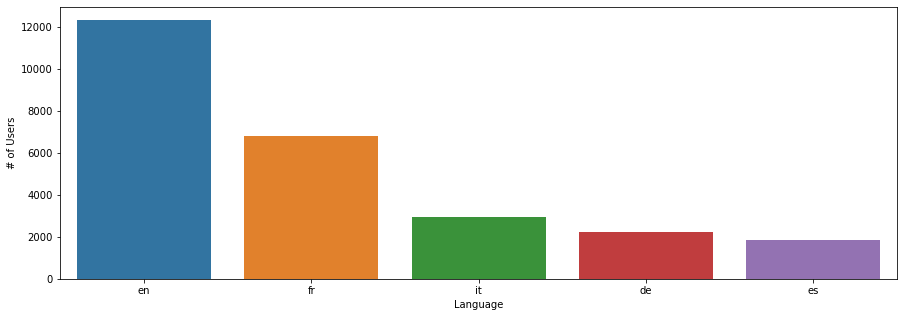

In [29]:
fig, al = plt.subplots(figsize=(15,5))
al = sns.barplot(app_l['language'].value_counts().index, app_l['language'].value_counts(), ax = al)
al.set(xlabel = 'Language', ylabel = '# of Users') 

We can also visualize the buying/selling tendencies by title. Women can identify as Mrs. or Miss based on their marriage status, but unfortunately we don't have a similar indicator for men. However, we see that married women account for a large majority of both products bought and sold. If the company wants to create more parity in their demographics, they could try targeting more ads to males as well as spotlighting/promoting active male sellers to males and married women (to purchase for their husbands or to suggest they use the app). 

In [30]:
app_ms = newdf[['civilityTitle','productsSold','productsBought']]
app_ms = app_ms.groupby(['civilityTitle']).sum().reset_index()
app_ms

,civilityTitle,productsSold,productsBought
0,miss,574,287
1,mr,2673,4262
2,mrs,8779,12457


C:\Users\jvasq\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



[Text(0.5, 0, 'Title'), Text(0, 0.5, 'Products Sold')]

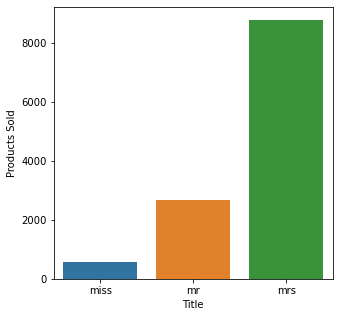

In [31]:
fig, am = plt.subplots(figsize=(5,5))
am = sns.barplot(app_ms['civilityTitle'], app_ms['productsSold'], ax = am)
am.set(xlabel= 'Title', ylabel= 'Products Sold')

C:\Users\jvasq\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



[Text(0.5, 0, 'Title'), Text(0, 0.5, 'Products Bought')]

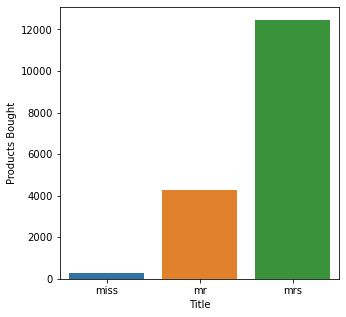

In [32]:
fig, ab = plt.subplots(figsize=(5,5))
ab = sns.barplot(app_ms['civilityTitle'], app_ms['productsBought'], ax = ab)
ab.set(xlabel= 'Title', ylabel= 'Products Bought')

As mentioned above, we have redundant columns so we will go ahead and drop those columns after we have examined them.

In [33]:
ndf = newdf.drop(['identifierHash','type','civilityTitle','civilityGenderId','hasAnyApp','country','countryCode','seniority','seniorityAsMonths','_merge'], axis=1)
ndf

,language,socialNbFollowers,socialNbFollows,socialProductsLiked,productsListed,productsSold,productsPassRate,productsWished,productsBought,gender,hasAndroidApp,hasIosApp,hasProfilePicture,daysSinceLastLogin,seniorityAsYears,region,sub-region
0,en,147,10,77,26,174,74.0,104,1,M,False,True,True,11,8.88,Europe,Northern Europe
1,en,167,8,2,19,170,99.0,0,0,F,False,True,True,12,8.90,Europe,Western Europe
2,fr,137,13,60,33,163,94.0,10,3,F,False,True,False,11,8.90,Europe,Western Europe
3,en,131,10,14,122,152,92.0,7,0,F,False,True,False,12,8.88,Americas,Northern America
4,en,167,8,0,25,125,100.0,0,0,F,False,False,True,22,7.93,Americas,Northern America
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98908,fr,3,8,0,0,0,0.0,0,0,M,False,False,True,708,8.90,Americas,Northern America
98909,fr,3,8,0,0,0,0.0,0,0,M,False,True,True,695,8.90,Europe,Western Europe
98910,en,3,8,0,0,0,0.0,0,0,M,True,False,True,520,8.90,Europe,Western Europe
98911,it,3,8,0,0,0,0.0,0,0,F,False,False,True,267,8.90,Europe,Southern Europe


I then create lists for the columns based on their data type, one for numerical columns and another for categorical columns.

In [34]:
cat_cols = []
num_cols = [] 
for col in ndf.columns:
    if (ndf[col].dtype == 'O') | (ndf[col].dtype == 'bool'):
        cat_cols.append(col)
    else:
        num_cols.append(col)
        
print('Cat cols: ',cat_cols)
print('Num cols: ',num_cols)

Cat cols:  ['language', 'gender', 'hasAndroidApp', 'hasIosApp', 'hasProfilePicture', 'region', 'sub-region']
Num cols:  ['socialNbFollowers', 'socialNbFollows', 'socialProductsLiked', 'productsListed', 'productsSold', 'productsPassRate', 'productsWished', 'productsBought', 'daysSinceLastLogin', 'seniorityAsYears']


After separating our data into categorical and numerical values, we can easily visualize the numerical values by making a histogram for each column. At first glance, we see that for most of these columns the values are skewed towards the lower end of the values. Revisiting the numerical description of our dataset, we see that most of these columns have max values that are much greater than the average so a few outliers are skewing the histograms.

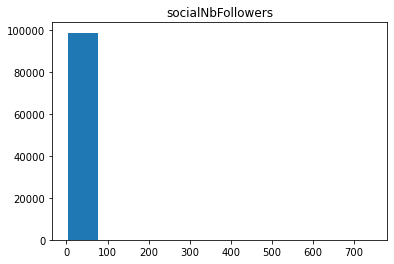

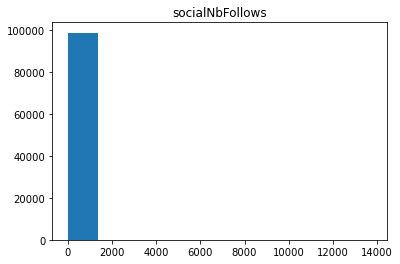

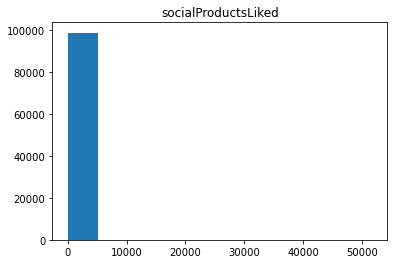

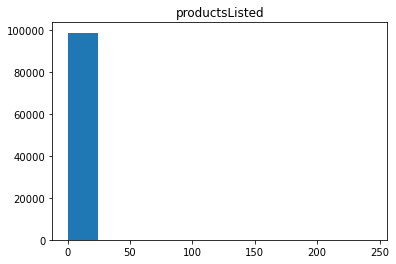

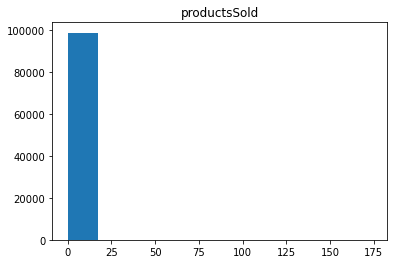

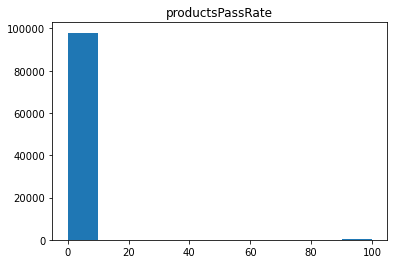

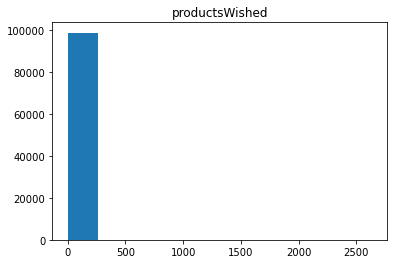

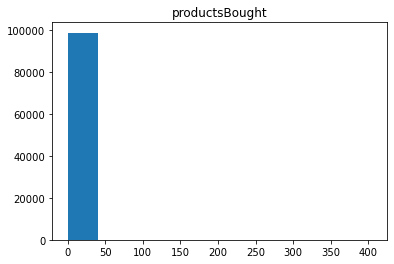

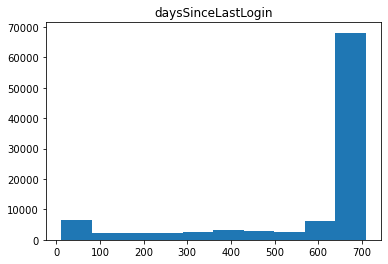

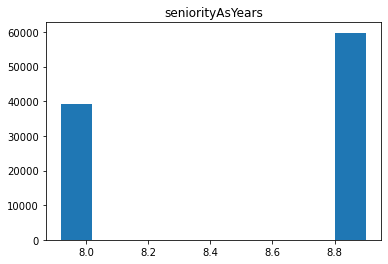

In [35]:
for i in num_cols:
    plt.hist(ndf[i])
    plt.title(i)
    plt.show()

To get a better idea of the columns with outliers, we recreate the histograms while removing the top 1% highest values to try to get a better representation. However we see that a large majority of users still fall into the one bin in each histogram. 

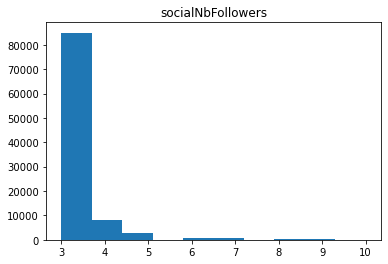

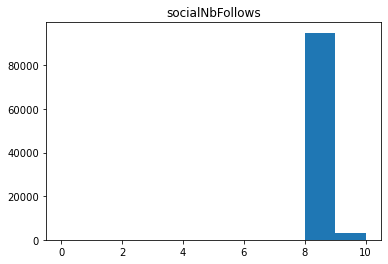

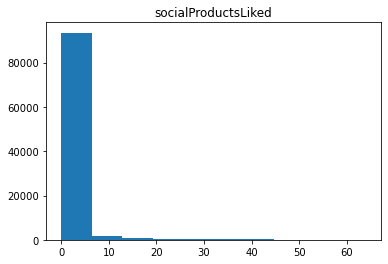

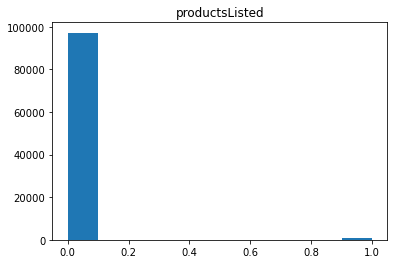

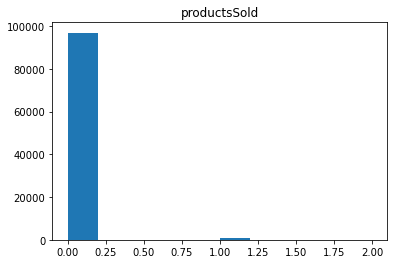

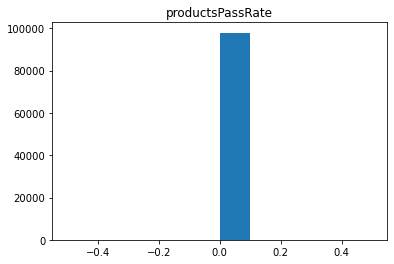

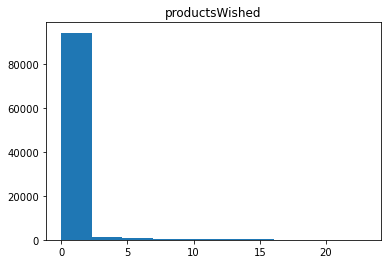

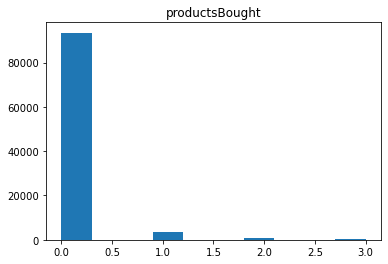

In [36]:
outlier_cols = ['socialNbFollowers', 'socialNbFollows', 'socialProductsLiked', 'productsListed', 'productsSold', 'productsPassRate', 'productsWished', 'productsBought']
for i in outlier_cols:
    plt.hist(ndf[i].sort_values(ascending = False)[990:], bins = 10)
    plt.title(i)
    plt.show()

We also make bar plots for the categorical features to get a better idea of the data. Since we already visualized what countries most users are from and what language they speak, we will remove this column from the categorical columns. Considering many of the countries included have relatively few users compared to the countries with the most users, this information will likely just add noise to our analysis. We should be able to get similar insights utilizing the region and sub-region information as countries with less users will be grouped into categories with more weight. 

In [37]:
cc_bars = cat_cols.copy()
x = ['language']
for i in x: 
    cc_bars.remove(i)

From graphing the categorical columns, we can see that: 

-Similar as when looking at products bought/sold, women make up an overwhelming majority of the users, but only a small fraction of them are single

-More users have the iOS app than the Android app, which is slightly surprising given how popular Android phones are outside of the United States

-Most users have a profile picture added on their accounts, adding to the fact that users do in fact utilize the social features

-We can see that the most common regions/sub-regions are in Europe and the Americas; not surprising as we saw that the five most common countries were from those regions

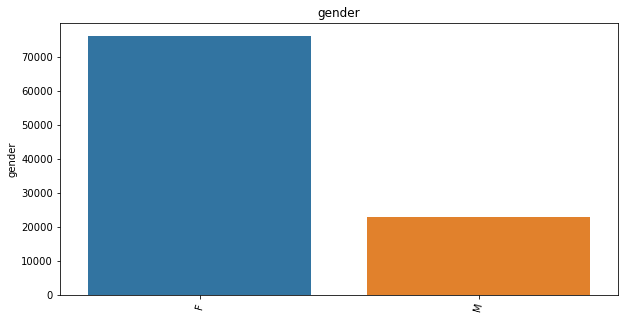

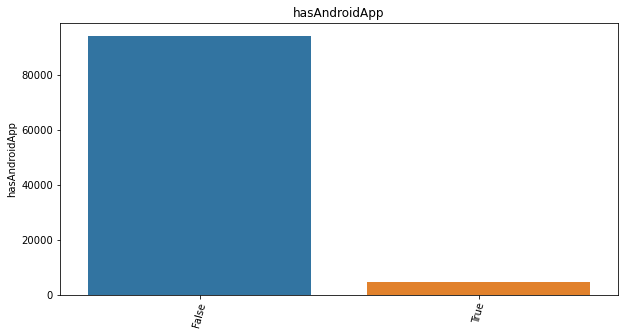

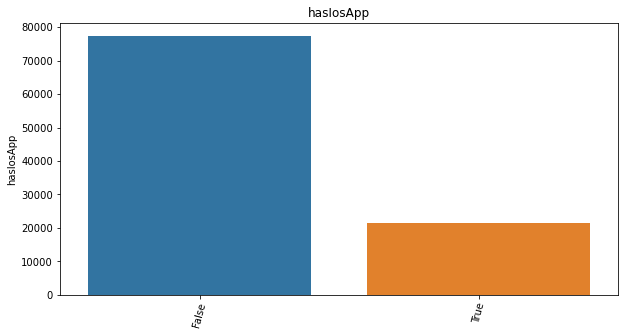

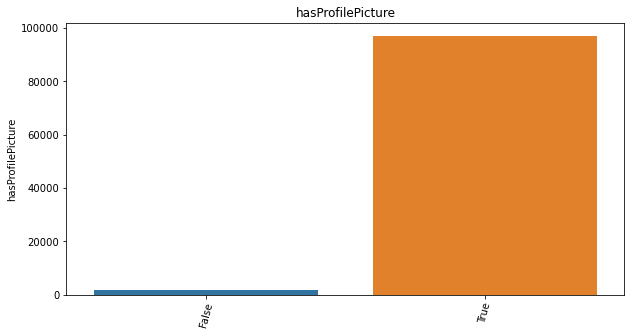

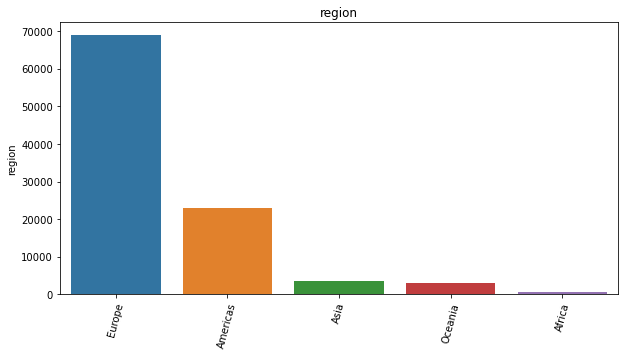

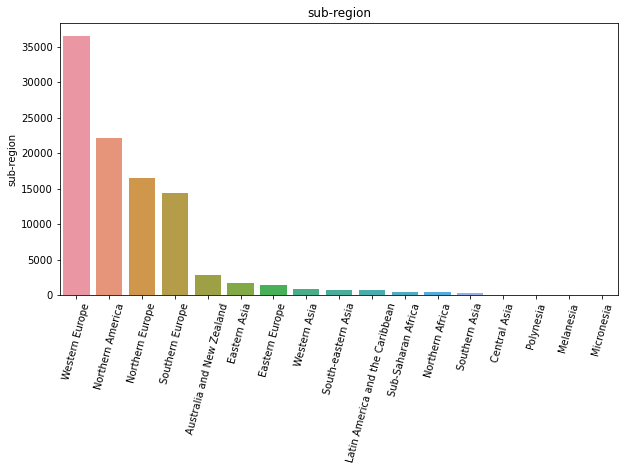

In [38]:
for i in cc_bars:
    fig, at = plt.subplots(figsize=(10,5))
    chart = sns.barplot(x = ndf[i].value_counts().index, y = ndf[i].value_counts(), ax = at)
    chart.set_title(i)
    chart.set_xticklabels(chart.get_xticklabels(), rotation = 75)
    plt.show()

# Clustering

From here, we scale our numerical data in order for us to be able to utilize it in our model, and then we will joining it with our categorical data to create an updated data frame.

In [39]:
numeric = ndf[num_cols]
numeric = StandardScaler().fit_transform(numeric.values)
scaled_features = pd.DataFrame(numeric, columns = num_cols)
scaled_features.head()

,socialNbFollowers,socialNbFollows,socialProductsLiked,productsListed,productsSold,productsPassRate,productsWished,productsBought,daysSinceLastLogin,seniorityAsYears
0,36.978910,0.029794,0.400918,12.636416,81.751466,8.610021,4.066096,0.355044,-2.730613,0.789912
1,42.130334,-0.008056,-0.013373,9.222052,79.870807,11.551097,-0.062027,-0.073719,-2.725825,0.832660
2,34.403198,0.086569,0.307012,16.050780,76.579656,10.962882,0.334908,1.212571,-2.730613,0.832660
3,32.857771,0.029794,0.052914,59.461980,71.407846,10.727596,0.215828,-0.073719,-2.725825,0.789912
4,42.130334,-0.008056,-0.024420,12.148650,58.713403,11.668740,-0.062027,-0.073719,-2.677944,-1.240614


In [40]:
scaled_ndf = scaled_features.join(ndf[cat_cols])
sdndf = pd.get_dummies(scaled_ndf, prefix = None, prefix_sep='_', dummy_na = False, columns = None,
                       sparse = False, drop_first = True, dtype = None)
sdndf

,socialNbFollowers,socialNbFollows,socialProductsLiked,productsListed,productsSold,productsPassRate,productsWished,productsBought,daysSinceLastLogin,seniorityAsYears,...,sub-region_Northern Africa,sub-region_Northern America,sub-region_Northern Europe,sub-region_Polynesia,sub-region_South-eastern Asia,sub-region_Southern Asia,sub-region_Southern Europe,sub-region_Sub-Saharan Africa,sub-region_Western Asia,sub-region_Western Europe
0,36.978910,0.029794,0.400918,12.636416,81.751466,8.610021,4.066096,0.355044,-2.730613,0.789912,...,0,0,1,0,0,0,0,0,0,0
1,42.130334,-0.008056,-0.013373,9.222052,79.870807,11.551097,-0.062027,-0.073719,-2.725825,0.832660,...,0,0,0,0,0,0,0,0,0,1
2,34.403198,0.086569,0.307012,16.050780,76.579656,10.962882,0.334908,1.212571,-2.730613,0.832660,...,0,0,0,0,0,0,0,0,0,1
3,32.857771,0.029794,0.052914,59.461980,71.407846,10.727596,0.215828,-0.073719,-2.725825,0.789912,...,0,1,0,0,0,0,0,0,0,0
4,42.130334,-0.008056,-0.024420,12.148650,58.713403,11.668740,-0.062027,-0.073719,-2.677944,-1.240614,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98905,-0.111343,-0.008056,-0.024420,-0.045507,-0.057165,-0.095565,-0.062027,-0.073719,0.606680,0.832660,...,0,1,0,0,0,0,0,0,0,0
98906,-0.111343,-0.008056,-0.024420,-0.045507,-0.057165,-0.095565,-0.062027,-0.073719,0.544435,0.832660,...,0,0,1,0,0,0,0,0,0,0
98907,-0.111343,-0.008056,-0.024420,-0.045507,-0.057165,-0.095565,-0.062027,-0.073719,-0.293479,0.832660,...,0,1,0,0,0,0,0,0,0,0
98908,-0.111343,-0.008056,-0.024420,-0.045507,-0.057165,-0.095565,-0.062027,-0.073719,-1.504864,0.832660,...,0,1,0,0,0,0,0,0,0,0


In [41]:
kmeans = KMeans(n_clusters = 7, init='k-means++')
kmeans.fit(sdndf)

print(silhouette_score(sdndf, kmeans.labels_, metric='euclidean'))

0.2553933500898354


In [42]:
pca = PCA(n_components = 0.75)
principalComponents = pca.fit_transform(sdndf)

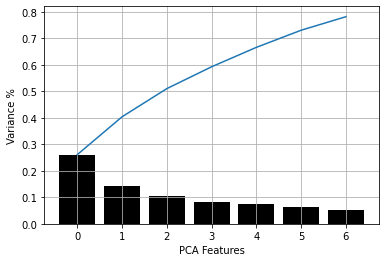

In [43]:
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('PCA Features')
plt.ylabel('Variance %')
plt.xticks(features)
plt.grid(visible=True)
plt.show()

In [44]:
PCs = pd.DataFrame(principalComponents)

In [45]:
PCs.shape

(98910, 7)

Text(0, 0.5, 'PCA 2')

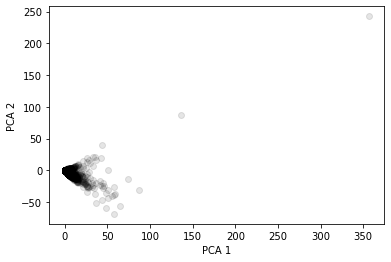

In [46]:
plt.scatter(PCs[0], PCs[1], alpha=.1, color='black')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

In [47]:
SSE = []

for cluster in range(1,30):
    kmeans = KMeans(n_clusters = cluster, init='k-means++')
    kmeans.fit(PCs)
    SSE.append(kmeans.inertia_)

Text(0, 0.5, 'Inertia')

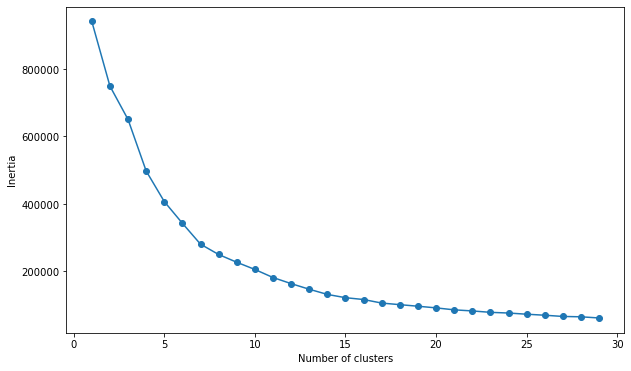

In [48]:
# converting the results into a dataframe and plotting them

frame = pd.DataFrame({'Cluster':range(1,30), 'SSE':SSE})
plt.figure(figsize=(10,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')